**Imports**

Data

In [1]:
#enter the path to get to your CDs_and_Vinyl folder below
PATH_TO_CDS = '../devided_dataset_v2/CDs_and_Vinyl/'

import pandas as pd

# Open and load json training files
x = pd.read_json(PATH_TO_CDS + 'train\\review_training.json')
y = pd.read_json(PATH_TO_CDS + 'train\\product_training.json')

Other

In [2]:
import numpy as np

PATCH TO SPEED UP (ONLY IF INTEL CHIP) 

lmao rip daniel

In [3]:
from sklearnex import patch_sklearn 

patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


**Pre Processing**

In [23]:
#z = pd.merge(x,y,'inner','asin')
#zgrouped = z.groupby("asin")

In [24]:
x #770786 entries
y #073082 entries

,asin,awesomeness
0,0000B049F5B33CD310EB1AB236E20191,1
1,00018184A9EC4D270219A296B2580303,0
2,000281A9CAC43FF1F335726A390636DA,0
3,00030884DF109F325638A6BFD5B13CFF,1
4,000325BA25966B5FC701D5D2B5DBA4E0,0
...,...,...
73077,FFFDD3C72D23AF858D6E0ED92612370D,1
73078,FFFDDE284A73B29B320381487EC7DE9E,1
73079,FFFEB3EE2372807964F024707D50FB21,0
73080,FFFF4545AB232D81D0F9B208388BB7AA,1


Feature creation testing

Making a single feature ex

In [7]:
reviewCount = x.groupby('asin')["reviewerID"].count()
reviewCount

asin
0000B049F5B33CD310EB1AB236E20191     4
00018184A9EC4D270219A296B2580303    18
000281A9CAC43FF1F335726A390636DA     4
00030884DF109F325638A6BFD5B13CFF    29
000325BA25966B5FC701D5D2B5DBA4E0     4
                                    ..
FFFDD3C72D23AF858D6E0ED92612370D    64
FFFDDE284A73B29B320381487EC7DE9E     4
FFFEB3EE2372807964F024707D50FB21     2
FFFF4545AB232D81D0F9B208388BB7AA     7
FFFF5A3D9CB0B40FF0FE6B95F05D26FE    27
Name: reviewerID, Length: 73082, dtype: int64

In [5]:
unixReviewMean = x.groupby('asin')['unixReviewTime'].mean()
unixReviewMean

asin
0000B049F5B33CD310EB1AB236E20191    1.296583e+09
00018184A9EC4D270219A296B2580303    1.111282e+09
000281A9CAC43FF1F335726A390636DA    1.254960e+09
00030884DF109F325638A6BFD5B13CFF    1.315392e+09
000325BA25966B5FC701D5D2B5DBA4E0    1.363802e+09
                                        ...     
FFFDD3C72D23AF858D6E0ED92612370D    1.258704e+09
FFFDDE284A73B29B320381487EC7DE9E    1.353758e+09
FFFEB3EE2372807964F024707D50FB21    1.349050e+09
FFFF4545AB232D81D0F9B208388BB7AA    1.427846e+09
FFFF5A3D9CB0B40FF0FE6B95F05D26FE    1.141706e+09
Name: unixReviewTime, Length: 73082, dtype: float64

Dropping ex

In [27]:
dropUnverified = x[x.verified != True]
dropUnverified

,asin,reviewerID,unixReviewTime,vote,verified,reviewTime,style,reviewerName,reviewText,summary,image
1,690819436E20BB31657AF6B58B984DD4,6E9ABBD26A27C2B2851D1EC34A01CBDC,1113523200,9,False,"04 15, 2005",{'Format:': ' Audio CD'},8DC0611245A871AC51BBEEBB85F33A58,These guys can sing! Such classic tunes...poi...,Under Appreciated....,None
2,A680D4753F0CEA2252C168A6ACB2B623,B637C3C93E61094474710F456928BE9F,1126137600,None,False,"09 8, 2005",None,2259386624CFA0EC53A75A50A9BB57A5,"Snoop Doggy Dogg made a classic album, DoggySt...",DoggyStyle,None
3,F4A966F1FA340B16651D676BC246D227,AA7918E9410D650A076221C7B2934A09,954979200,None,False,"04 6, 2000",{'Format:': ' Audio CD'},7A65A155C993535BC99CBCB39E7161B5,Stevie Nicks Has had Her Moments. I Like Some ...,Pretty Good but a Bit Dated,None
5,53F7DB69E39E3E6F443107964A197EF2,B62364696E8A2EA88E42FE885749893A,1342483200,None,False,"07 17, 2012",{'Format:': ' Audio CD'},7FE2EED9AE800162228DBCF6FAF57D16,This album is 2 stars because some of the song...,2/5,None
6,227BB436F8D070C633065188BA5E86B8,44E089A2E50AD3C40460E3476E44FB97,1422835200,None,False,"02 2, 2015",None,5FA5B57C2222EBC96BFF92A9837ADE77,The new Rock or Bust album sounds like it was ...,The new Rock or Bust album sounds like it was ...,None
...,...,...,...,...,...,...,...,...,...,...,...
770777,D1252C5B6CB821FC38F5681FFEDE7424,067B15441E9FAD6BC033B1F2DA99587E,1282867200,None,False,"08 27, 2010",{'Format:': ' Audio CD'},94D644AB716093162A84FE4D60EEA75E,--superb rockin' soul pop folk music.\n--tunes...,SHE'S TOPS!,None
770782,9BC50277D18FAB423AD33C8CE4CC000D,EF922377A87E9D01F50065F2DA1722A8,1290556800,None,False,"11 24, 2010",None,0441BC4F6B7BD180769FDCDD8E603560,I have owned a CD copy of this show for at lea...,Forgettable R&H,None
770783,4062627CA1586E517520483964299349,E1F0B0EBC6A36F33301E4FD0B3D62D52,1311120000,3,False,"07 20, 2011",{'Format:': ' Audio CD'},8AB3EEBF23F3583A4396A57DB291D548,carnival of souls to me is bad i gave my cd aw...,Darren d.,None
770784,0AE44A6A9176E6A52507B6ABDDA80B00,DDDC81E6B8C3F8C91867F9AECB385135,1111968000,2,False,"03 28, 2005",{'Format:': ' Audio CD'},51B2E62E0A5864316BDB33FD4A729B37,This is an awesome slayer album. I love the th...,awesome slayer cd,None


groupby() testing

In [ ]:
tests = range(5)
unique_items = z["asin"].nunique()
print("ui: ", unique_items)

asin = z["asin"].values
print("asin: ",asin)
avg_votes = np.zeros(len(asin))

for i in tests: # eventually all
    item = zgrouped.get_group(asin[i])
    avg_votes[i] = item["vote"].fillna(0).astype(int).mean()

print("avg_votes: ", avg_votes[0:5])

**Testing**

Test example: 

*Gaussian Naive Bayes with tfidf*

In [ ]:
from sklearn.model_selection import train_test_split

from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()

from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()

#split data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5, random_state=0)

#train and apply tfidf
    # fit = make vocab 
    # transform = turn words -> numbers
x_train = tfidf.fit_transform(x_train).toarray()
x_test = tfidf.transform(x_test).toarray()

#make prediction
y_pred = gnb.fit(x_train, y_train).predict(x_test)

#print accuracy
print(f"Number of mislabeled points out of a total {x_test.shape[0]} points : {(y_test != y_pred).sum()}")

# Models

(choose one)

Basic Support Vector Machine (SVM)

In [9]:
from sklearn import svm

model = svm.SVC(kernel='rbf')

Basic Gaussian Naive Bayes

In [44]:
from sklearn.naive_bayes import GaussianNB

model = GaussianNB()

Decision Tree

In [29]:
from sklearn import tree

#choose from 'entropy', 'gini', 'log_loss'
criterion = 'entropy'

    ###STOPPING CONDITIONS
#max height/depth of the tree
max_depth = 4

#if sat(N) < n_samples*this, don't try to split it any further
min_samples_split = .01

    ###OTHER
#if min(sat(nodes after a split)) < n_samples*this, split not considered 
#       (aka model isnt allowed to create leaf nodes with < n_samples*this samples)
#       (smooths the model, avoids splits like 2000 -> 1999 vs 1)
min_samples_leaf = .01

model = tree.DecisionTreeClassifier(criterion=criterion, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)

For reference: What x,y should look like

In [ ]:
from sklearn.datasets import load_iris

iris = load_iris()

#iris.data
#iris.target

# Testing prep

Put feature vector with col 1 as 'asin' to *z*, answers to *y*

In [77]:
#combine all individual features into one dataFrame

#enter any features to be combined here! 
#   They must be pd dataFrames with the 'asin' column for this to work
features = [reviewCount,unixReviewMean]

z = x['asin']
for f in features:
    z = pd.merge(z,f,'inner','asin')

#combine resultant data with correct answers 
temp = pd.merge(z,y,'inner','asin')

#split into features (x) and awesomeness (y), which now row correspond but don't have an 'asin' col anymore
merged_x = temp.drop(['asin','awesomeness'], axis=1)
merged_y = temp["awesomeness"]

,asin,reviewerID,unixReviewTime,awesomeness
0,6673F1740E03573BCD64238FE711FC69,14577,1.385490e+09,1
1,6673F1740E03573BCD64238FE711FC69,14577,1.385490e+09,1
2,6673F1740E03573BCD64238FE711FC69,14577,1.385490e+09,1
3,6673F1740E03573BCD64238FE711FC69,14577,1.385490e+09,1
4,6673F1740E03573BCD64238FE711FC69,14577,1.385490e+09,1
...,...,...,...,...
770781,928CCBB9A92106966827DE24214976BC,1,1.381450e+09,1
770782,431D15AA55CF51F5BF1E7D5E4B854B22,1,1.453766e+09,0
770783,2DA5B27AFDEF44C647111CAC58E92868,1,1.374365e+09,1
770784,0E27343B95E949FC7EB4F03E0AD873A6,1,1.080778e+09,0


Decision Tree - See what it looks like! 

(only run if the model is a decision tree)

*note: this trains the model on the whole dataset, so don't do before testing!*

[Text(0.5625, 0.9, 'x[0] <= 1352.0\nentropy = 0.995\nsamples = 770786\nvalue = [352485, 418301]'),
 Text(0.5, 0.7, 'x[1] <= 1250452160.0\nentropy = 0.997\nsamples = 754487\nvalue = [352485, 402002]'),
 Text(0.25, 0.5, 'x[1] <= 1068781888.0\nentropy = 0.999\nsamples = 279032\nvalue = [144313, 134719]'),
 Text(0.125, 0.3, 'x[1] <= 1037642400.0\nentropy = 0.961\nsamples = 19838\nvalue = [12204, 7634]'),
 Text(0.0625, 0.1, 'entropy = 0.944\nsamples = 8145\nvalue = [5198, 2947]'),
 Text(0.1875, 0.1, 'entropy = 0.971\nsamples = 11693\nvalue = [7006, 4687]'),
 Text(0.375, 0.3, 'x[1] <= 1242063296.0\nentropy = 1.0\nsamples = 259194\nvalue = [132109, 127085]'),
 Text(0.3125, 0.1, 'entropy = 1.0\nsamples = 239299\nvalue = [120100, 119199]'),
 Text(0.4375, 0.1, 'entropy = 0.969\nsamples = 19895\nvalue = [12009, 7886]'),
 Text(0.75, 0.5, 'x[0] <= 143.5\nentropy = 0.989\nsamples = 475455\nvalue = [208172, 267283]'),
 Text(0.625, 0.3, 'x[0] <= 36.5\nentropy = 0.991\nsamples = 439964\nvalue = [196110

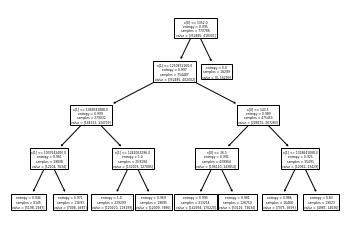

In [75]:
model.fit(merged_x,merged_y)
tree.plot_tree(model)

# Testing

K-Fold testing 

(set model to variable *model*)

In [30]:
from sklearn.model_selection import cross_validate
from sklearn import metrics

#desired metrics
scoring=['f1','accuracy','precision','recall']

#number of "folds"
k=10

cv_results = cross_validate(model, merged_x, merged_y, cv=k, scoring=scoring)

Pretty print results

In [71]:
hline = ("-"*40)

#print means, stdevs
print(hline+"\n\tAVG, STDEV TEST RESULTS\n"+hline)
print("\t\tMEAN\t\tSTDEV")
for m in scoring:
        ind = ("test_"+m)
        test = (m+":").ljust(10)
        print(f"{test}\t{np.round(cv_results[ind].mean(),4)}\t\t{np.round(cv_results[ind].std(),4)}")


    ##print per test results (if you really want, uncomment)
# print("\n")
# print(hline+"\n\tPER TEST RESULTS\n"+hline)
# for i in range(k):
#     print(f"Test {i}:")
#     for m in scoring:
#         ind = ("test_"+m)
#         test = (m+":").ljust(10)
#         print(f"\t{test} {np.round(cv_results[ind][i],5)}")

----------------------------------------
	AVG, STDEV TEST RESULTS
----------------------------------------
		MEAN		STDEV
f1:       	0.671		0.005
accuracy: 	0.5477		0.0027
precision:	0.5473		0.002
recall:   	0.8673		0.0189
